
# Periodic features
Feature Engineering for Time Series Forecasting

Periodic features are those that repeat their values at regular intervals, like the hour, the days of a week, and the months of a year.

With cyclical or periodic features, values that are very different in absolute magnitude are actually close. For example, January is close to December, even though their absolute magnitude suggests otherwise.

We can use periodic functions like sine and cosine, to transform cyclical features and help machine learning models pick up their intrinsic nature.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Create toy data

In [2]:
# let's create a dataframe with the hour from 0 to 23
df = pd.DataFrame([i for i in range(24)], columns=['hour'])

df.head()

,hour
0,0
1,1
2,2
3,3
4,4


Let's determine the time elapsed between the hours 3 and 1

In [3]:
df.iloc[3] - df.iloc[1]

hour    2
dtype: int64

As expected, there is a 2 hours difference.\
Now, let's determine the difference between 22 hours and midnight, that is 2 hours.

In [4]:
df.iloc[22] - df.iloc[0]

hour    22
dtype: int64

As we see, there is a 22-hour difference, when we actually know that there is only a 2 hours difference.\
How can we make sure ML models better understand the real difference between the values of cyclical features?

## Sine and cosine transformations

In [5]:
# transform the features with the sine and cosine functions
df['hour_sin'] = np.sin(df['hour'] / df['hour'].max() * 2 * np.pi)
df['hour_cos'] = np.cos(df['hour'] / df['hour'].max() * 2 * np.pi)

df.head()

,hour,hour_sin,hour_cos
0,0,0.000000,1.000000
1,1,0.269797,0.962917
2,2,0.519584,0.854419
3,3,0.730836,0.682553
4,4,0.887885,0.460065


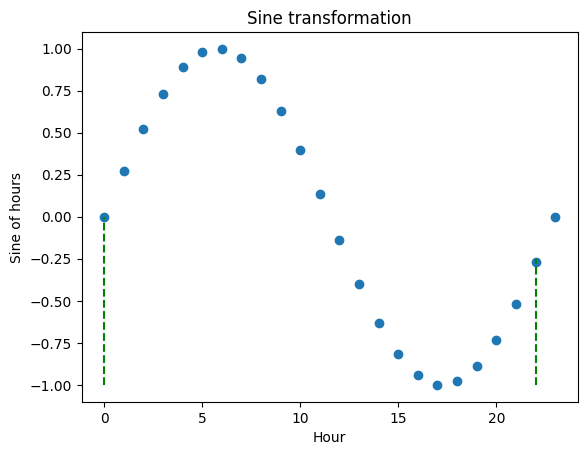

In [6]:
# plot hour vs its trigonometric transformations
plt.scatter(df['hour'], df['hour_sin'])

# axis labels
plt.ylabel('Sine of hours')
plt.xlabel('Hour')
plt.title('Sine transformation')

plt.vlines(x=0, ymin=-1, ymax=0, color='g', linestyles='--')
plt.vlines(x=22, ymin=-1, ymax=-0.25, color='g', linestyles='--')

After the transformation we see that the hours 0 and 22 are much closer in value.\
But, we also observe that the different hours could take the same value after the transformation, see below:

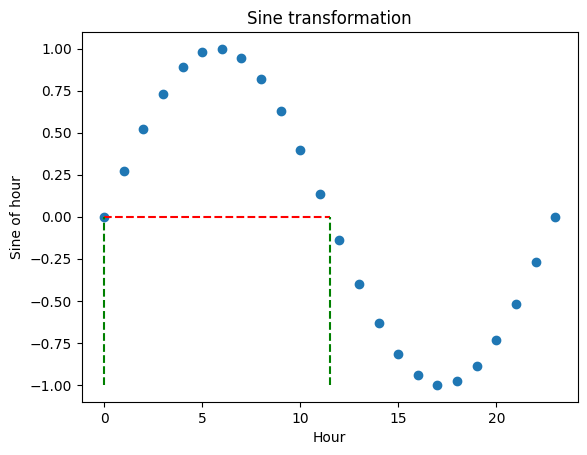

In [7]:
# plot hour vs its trigonometric transformation
plt.scatter(df['hour'], df['hour_sin'])

# axis labels
plt.ylabel('Sine of hour')
plt.xlabel('Hour')
plt.title('Sine transformation')

plt.hlines(y=0, xmin=0, xmax=11.5, color='r', linestyles='--')
plt.vlines(x=0, ymin=-1, ymax=0, color='g', linestyles='--')
plt.vlines(x=11.5, ymin=-1, ymax=0, color='g', linestyles='--')


In the precedent plot, we see the the hours 0 and 11.5 take roughly the same value after the sin transformation.

The same is true for the cosine function, see below:

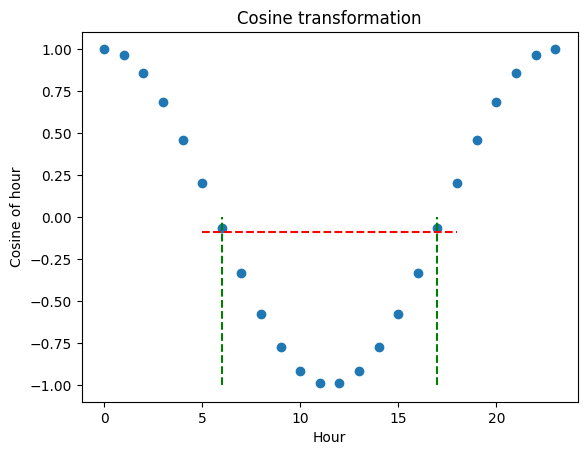

In [9]:
# plot hour vs its trigonometric transformation
plt.scatter(df['hour'], df['hour_cos'])

# axis labels
plt.ylabel('Cosine of hour')
plt.xlabel('Hour')
plt.title('Cosine transformation')

plt.hlines(y=-0.09, xmin=5, xmax=18, color='r', linestyles='--')
plt.vlines(x=6, ymin=-1, ymax=0, color='g', linestyles='--')
plt.vlines(x=17, ymin=-1, ymax=0, color='g', linestyles='--')


In the former plot, we see that the hours 6 and 17 take roughly the same cosine value after the transformation.

How can we distinguish the hours 0 from 11.5 or 6 from 17?

We need to use the 2 transformations together to fully code the information of the hour. Adding the cosine function, which is out-of-phase with the sine function, breaks the symmetry and gives each hour a unique codification.

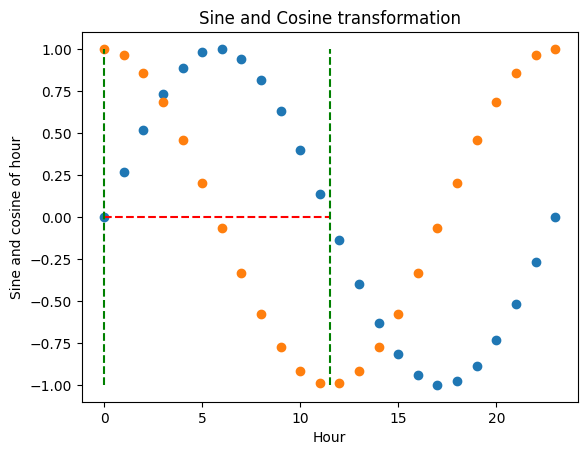

In [10]:
# Plot hour vs its trigonometric transformation.

plt.scatter(df["hour"], df["hour_sin"])
plt.scatter(df["hour"], df["hour_cos"])

# Axis labels
plt.ylabel('Sine and cosine of hour')
plt.xlabel('Hour')
plt.title('Sine and Cosine transformation')


plt.hlines(y=0, xmin=0, xmax=11.5, color='r', linestyles='dashed')

plt.vlines(x=0, ymin=-1, ymax=1, color='g', linestyles='dashed')
plt.vlines(x=11.5, ymin=-1, ymax=1, color='g', linestyles='dashed')


With the values of sine 0 and cosine 1, we can unequivocally identify the hour 0. With the values of sine 0 and cosine -1 we can unequivocally identify the hour 11.5 and so on.

An intuitive way to show the new representation is to plot the sine vs the cosine transformation of the hour. It will show as a 24 hour clock, and now, the distance between two points corresponds to the difference in time as we would expect from a 24-hour cycle.

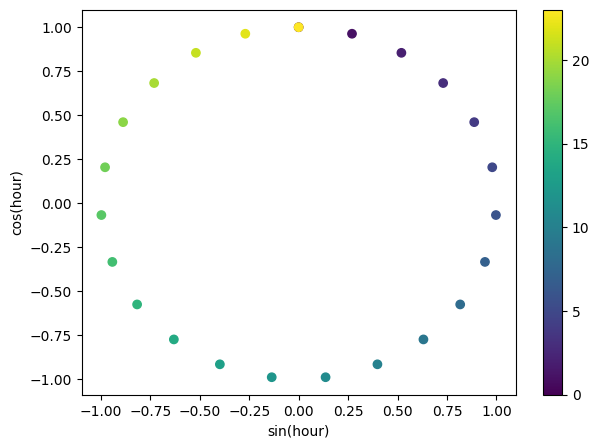

In [11]:
fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(df["hour_sin"], df["hour_cos"], c=df["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

Now we can go ahead and apply this transformation to some real data.

In [12]:
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures

from sklearn.pipeline import Pipeline

## Pollutants

Let's work with the air quality dataset that we created in the notebook **03-prepare-air-quality-dataset** which you can find in the folder **01-Create-Datasets** in this repo.

In [13]:
# function to load and prepare input data
def load_data():
    filename = '../datasets/AirQualityUCI_ready.csv'

    # load data
    data = pd.read_csv(filename, usecols=['Date_Time', 'CO_sensor'])

    # cast date variable in datetime format
    data['Date_Time'] = pd.to_datetime(data['Date_Time'])

    # set the index to the timestamp
    data.index = data['Date_Time']

    # sanity - sort index
    data.sort_index(inplace=True)

    # reduce data span
    data = data[
        (data['Date_Time'] >= '2004-04-01') &
        (data['Date_Time'] <= '2005-04-30')
    ]

    # remove outliers
    data = data.loc[(data['CO_sensor'] > 0)]

    return data

In [14]:
# load data
data = load_data()

data.head()

,Date_Time,CO_sensor
Date_Time,,
2004-04-04 00:00:00,2004-04-04 00:00:00,1224.0
2004-04-04 01:00:00,2004-04-04 01:00:00,1215.0
2004-04-04 02:00:00,2004-04-04 02:00:00,1115.0
2004-04-04 03:00:00,2004-04-04 03:00:00,1124.0
2004-04-04 04:00:00,2004-04-04 04:00:00,1028.0


## Add temporal features
We will extract year, month, and hour from the index

In [15]:
# extract month and hour from the timestamp
dtf = DatetimeFeatures(
    variables='Date_Time',
    features_to_extract=['year', 'month', 'hour'],
    drop_original=True,
)

# extract the datetime features
data = dtf.fit_transform(data)

data.head()

,CO_sensor,Date_Time_year,Date_Time_month,Date_Time_hour
Date_Time,,,,
2004-04-04 00:00:00,1224.0,2004,4,0
2004-04-04 01:00:00,1215.0,2004,4,1
2004-04-04 02:00:00,1115.0,2004,4,2
2004-04-04 03:00:00,1124.0,2004,4,3
2004-04-04 04:00:00,1028.0,2004,4,4


## Hourly pollutant concentration

Text(0.5, 1.0, 'CO concentration in time')

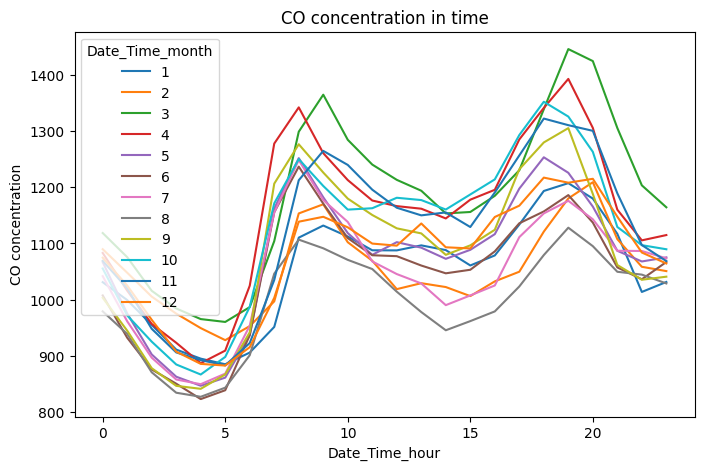

In [16]:
# mean pollutant concentration per hour
data.groupby(['Date_Time_hour', 'Date_Time_month'])['CO_sensor'].mean().unstack().plot(figsize=(8, 5))

plt.ylabel('CO concentration')
plt.title('CO concentration in time')

## Monthly pollutant concentration

Text(0.5, 1.0, 'CO concentration in time')

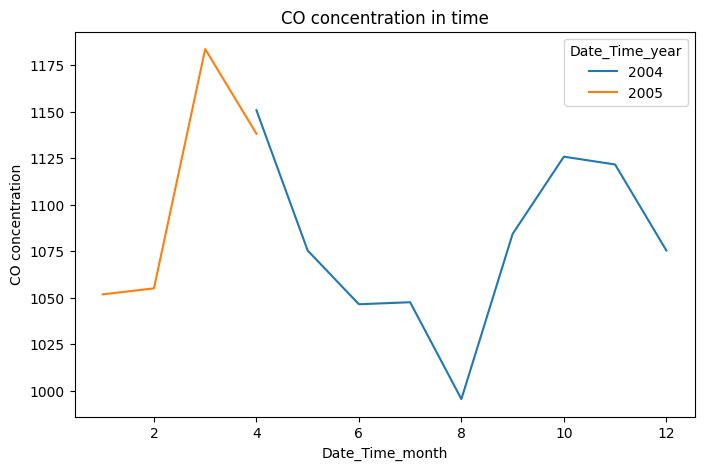

In [17]:
# mean pollutant concentration per month
data.groupby(['Date_Time_month', 'Date_Time_year'])['CO_sensor'].mean().unstack().plot(figsize=(8, 5))

plt.ylabel('CO concentration')
plt.title('CO concentration in time')

We do not have enough info to conclude that there is monthly seasonality. We would need more years of information.

## Periodic transformation
Let's transform the features with the sine and cosin manually

Text(0.5, 1.0, 'Sine transformation of hour')

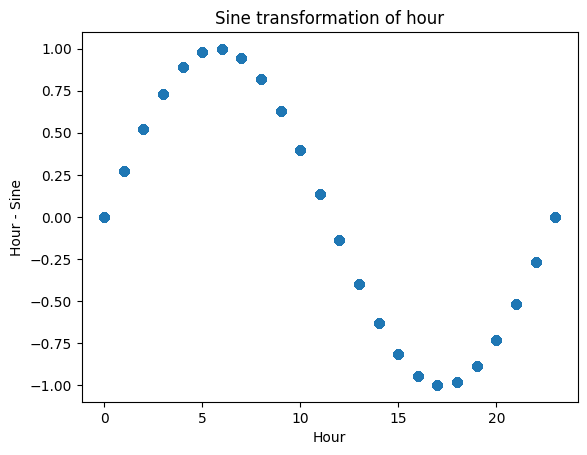

In [18]:
# transform hour with sine
data['hour_sin'] = np.sin(data['Date_Time_hour'] / 
                          data['Date_Time_hour'].max() * 2 * np.pi)

# plot
plt.scatter(data['Date_Time_hour'], data['hour_sin'])

# axis labels
plt.xlabel('Hour')
plt.ylabel('Hour - Sine')
plt.title('Sine transformation of hour')

Text(0.5, 1.0, 'Cosine transformation of hour')

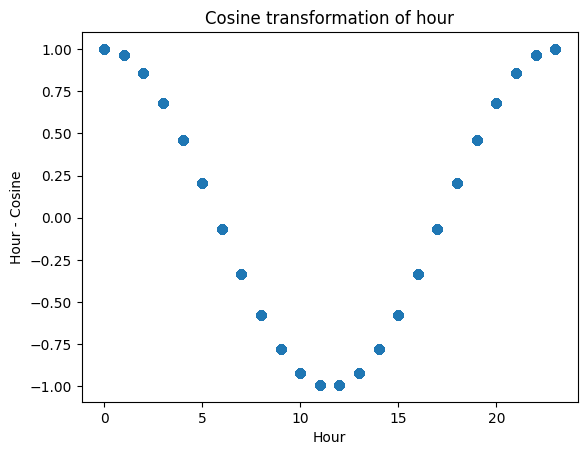

In [19]:
# transform hour with cosine
data['hour_cos'] = np.cos(data['Date_Time_hour'] / 
                          data['Date_Time_hour'].max() * 2 * np.pi)

# plot
plt.scatter(data['Date_Time_hour'], data['hour_cos'])

# axis labels
plt.xlabel('Hour')
plt.ylabel('Hour - Cosine')
plt.title('Cosine transformation of hour')

## Automate with Feature-engine

In [20]:
# load data
data = load_data()

data.head()

,Date_Time,CO_sensor
Date_Time,,
2004-04-04 00:00:00,2004-04-04 00:00:00,1224.0
2004-04-04 01:00:00,2004-04-04 01:00:00,1215.0
2004-04-04 02:00:00,2004-04-04 02:00:00,1115.0
2004-04-04 03:00:00,2004-04-04 03:00:00,1124.0
2004-04-04 04:00:00,2004-04-04 04:00:00,1028.0


In [21]:
# get datetime features from the datetime variable
# and apply periodic transformation
pipe = Pipeline(
    [
        # create datetime features
        ('datetime', DatetimeFeatures(
            variables='Date_Time',
            features_to_extract=['month', 'hour'],
            drop_original=True,
        )),
        # apply sine and cosine transformation
        ('cyclical', CyclicalFeatures(
            variables=['Date_Time_month', 'Date_Time_hour'],
        )),
    ]
)

In [22]:
# extract the features
data = pipe.fit_transform(data)

data.head()

,CO_sensor,Date_Time_month,Date_Time_hour,Date_Time_month_sin,Date_Time_month_cos,Date_Time_hour_sin,Date_Time_hour_cos
Date_Time,,,,,,,
2004-04-04 00:00:00,1224.0,4,0,0.866025,-0.5,0.000000,1.000000
2004-04-04 01:00:00,1215.0,4,1,0.866025,-0.5,0.269797,0.962917
2004-04-04 02:00:00,1115.0,4,2,0.866025,-0.5,0.519584,0.854419
2004-04-04 03:00:00,1124.0,4,3,0.866025,-0.5,0.730836,0.682553
2004-04-04 04:00:00,1028.0,4,4,0.866025,-0.5,0.887885,0.460065


## Compare model performance
Now, let's compare the performance of a model trained with the raw features or the trigonometric transformed features.

NOTE: I am going to do a quick and dirty job to prove my point. Keep in mind that we should split the data into a train and a test set or use cross-validation to have an accurate measure of the model performance.

In [23]:
from sklearn.linear_model import Lasso

In [24]:
# lasso regression
reg = Lasso(random_state=10)

In [25]:
# fit lasso to the raw inputs
reg.fit(data[['Date_Time_month', 'Date_Time_hour']], data['CO_sensor'])

# get the R2
reg.score(data[['Date_Time_month', 'Date_Time_hour']], data['CO_sensor'])

0.10359654878036195

In [26]:
# Capture the trigonometrically transformed variables in a list.

trig_vars = [var for var in data.columns if 'sin' in var or 'cos' in var]

trig_vars

['Date_Time_month_sin',
 'Date_Time_month_cos',
 'Date_Time_hour_sin',
 'Date_Time_hour_cos']

In [27]:
# Fit Lasso with transformed inputs.

reg.fit(data[trig_vars], data["CO_sensor"])

# Get the R2.
reg.score(data[trig_vars], data["CO_sensor"])

0.13263074168408584

As we see, with the transformed features we improved the performance of the model by roughly 30%.

More details on working with temporal features in the Scikit-learn docs